# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [72]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

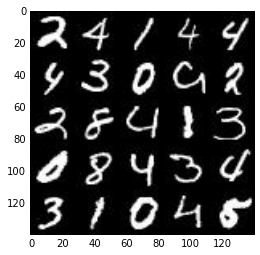

In [73]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

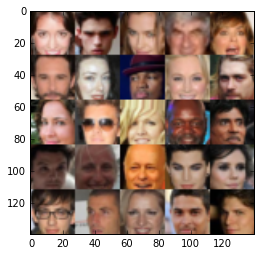

In [74]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [76]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(dtype=tf.float32,shape=(None,image_width,image_height,image_channels),name="input_real")
    inputs_z = tf.placeholder(dtype=tf.float32,shape=(None,z_dim),name="input_z")
    lr_placeholder = tf.placeholder(dtype=tf.float32,name="lr_placeholder")

    return inputs_real, inputs_z, lr_placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [77]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Input layer is 28x28x3 or 28x28x1
        i1 = tf.contrib.layers.xavier_initializer()
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same',kernel_initializer=i1)
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        i2 = tf.contrib.layers.xavier_initializer()
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same',kernel_initializer=i2)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        i3 = tf.contrib.layers.xavier_initializer()
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same',kernel_initializer=i3)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [78]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*224)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 224))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x224 now
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x112 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x56 now

        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [79]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [80]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [81]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [82]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Normalize inputs
                batch_images *= 2

                # Random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # g optimizer is run multiple times
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                # _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})


                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 1.9967
Epoch 1/2... Discriminator Loss: 2.0304... Generator Loss: 1.3439
Epoch 1/2... Discriminator Loss: 1.6105... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.7790... Generator Loss: 1.1307
Epoch 1/2... Discriminator Loss: 1.6409... Generator Loss: 1.0856
Epoch 1/2... Discriminator Loss: 1.6490... Generator Loss: 1.1155
Epoch 1/2... Discriminator Loss: 1.6255... Generator Loss: 1.2706
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 1.0267
Epoch 1/2... Discriminator Loss: 1.6477... Generator Loss: 1.3077
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 1.2328


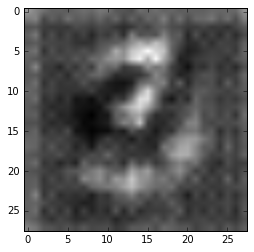

Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 1.1783
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 1.1678
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 1.4657
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 1.1468
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 1.1001
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 1.0093
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 1.4622


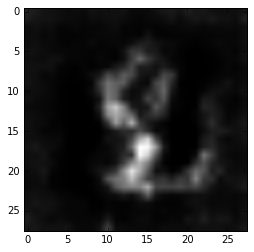

Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 1.3350
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 1.2274
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 1.1195
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 1.0549
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 1.4064
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 0.7018
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.3799


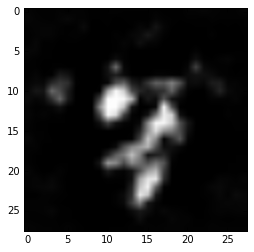

Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 1.5805... Generator Loss: 0.2818
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.9613... Generator Loss: 0.1739
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.3622
Epoch 1/2... Discriminator Loss: 1.7618... Generator Loss: 0.2213
Epoch 1/2... Discriminator Loss: 1.6954... Generator Loss: 0.2395
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.4343
Epoch 1/2... Discriminator Loss: 1.6036... Generator Loss: 0.2912


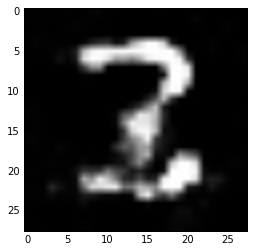

Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.8967
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 1.0267
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.9003
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.9015
Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 1.0386
Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 1.0229
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.9871
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 1.1323


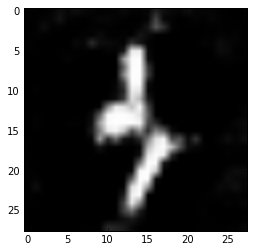

Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 1.0213
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.8167
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 1.0708
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.9942
Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.7431


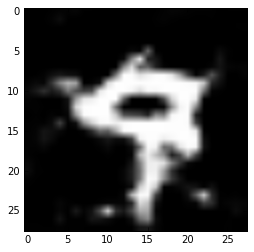

Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.9692
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.5798
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 1.0059
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 1.8500... Generator Loss: 1.6028
Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 0.6476
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.3545


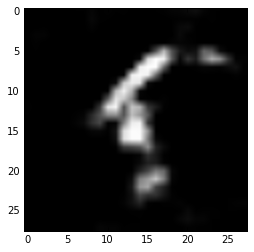

Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.3452
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 1.1395
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.3793
Epoch 1/2... Discriminator Loss: 1.9598... Generator Loss: 0.1821
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.4827
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.3003
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.3648


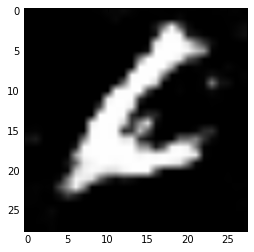

Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.3477
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.4271
Epoch 1/2... Discriminator Loss: 1.8582... Generator Loss: 0.2126
Epoch 1/2... Discriminator Loss: 1.7389... Generator Loss: 0.2402
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.3887
Epoch 1/2... Discriminator Loss: 1.7068... Generator Loss: 0.2644
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.4131


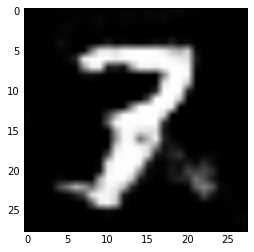

Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.3924
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 1.2716
Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.3689
Epoch 2/2... Discriminator Loss: 1.4642... Generator Loss: 0.3415
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.3990
Epoch 2/2... Discriminator Loss: 1.5358... Generator Loss: 0.2888
Epoch 2/2... Discriminator Loss: 1.7069... Generator Loss: 0.2693
Epoch 2/2... Discriminator Loss: 1.4445... Generator Loss: 0.3657
Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 1.5844
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.9588


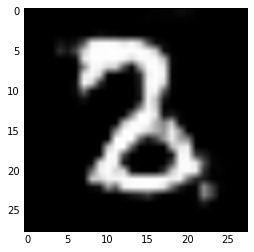

Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.6039
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.3525
Epoch 2/2... Discriminator Loss: 1.2612... Generator Loss: 0.4653
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 0.4694
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.9547
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.9216
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.4935
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.3384
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.4854


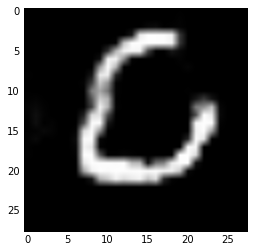

Epoch 2/2... Discriminator Loss: 1.7126... Generator Loss: 0.2427
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.4109
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 0.6523
Epoch 2/2... Discriminator Loss: 2.7232... Generator Loss: 0.0956
Epoch 2/2... Discriminator Loss: 2.0461... Generator Loss: 0.1720
Epoch 2/2... Discriminator Loss: 1.9343... Generator Loss: 0.1882
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.4133
Epoch 2/2... Discriminator Loss: 1.7410... Generator Loss: 2.1524
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.5760
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.4679


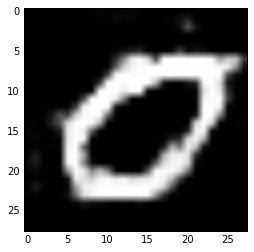

Epoch 2/2... Discriminator Loss: 1.1280... Generator Loss: 0.5690
Epoch 2/2... Discriminator Loss: 1.9622... Generator Loss: 0.1924
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.5237
Epoch 2/2... Discriminator Loss: 2.2409... Generator Loss: 2.2950
Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 0.3744
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 0.6042
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.4288
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 0.4718


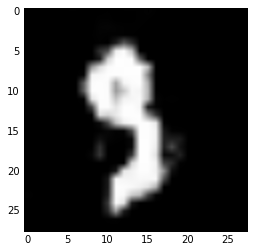

Epoch 2/2... Discriminator Loss: 1.4623... Generator Loss: 0.3304
Epoch 2/2... Discriminator Loss: 1.5292... Generator Loss: 0.2931
Epoch 2/2... Discriminator Loss: 2.5316... Generator Loss: 0.1053
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.4187
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 1.5629... Generator Loss: 0.3250
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.4488... Generator Loss: 0.3497
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 0.3964


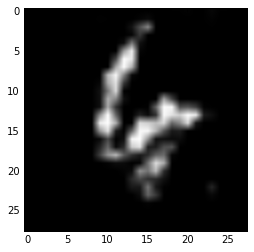

Epoch 2/2... Discriminator Loss: 1.5761... Generator Loss: 0.2853
Epoch 2/2... Discriminator Loss: 1.5638... Generator Loss: 0.3288
Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 1.7276
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.3225
Epoch 2/2... Discriminator Loss: 1.5925... Generator Loss: 0.3132
Epoch 2/2... Discriminator Loss: 1.7393... Generator Loss: 0.2490
Epoch 2/2... Discriminator Loss: 1.9293... Generator Loss: 0.1870
Epoch 2/2... Discriminator Loss: 1.7091... Generator Loss: 0.2453


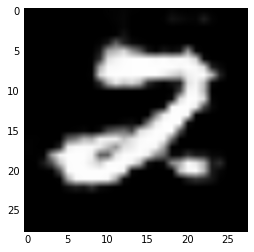

Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 0.6215
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.4884
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 0.8919
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 1.6411
Epoch 2/2... Discriminator Loss: 1.0725... Generator Loss: 1.3788
Epoch 2/2... Discriminator Loss: 1.8603... Generator Loss: 0.2139
Epoch 2/2... Discriminator Loss: 1.8796... Generator Loss: 0.2164
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.9173
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.3905


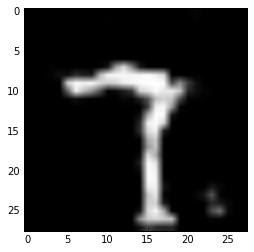

Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.5185
Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 0.3265
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.4172
Epoch 2/2... Discriminator Loss: 2.0138... Generator Loss: 0.1845
Epoch 2/2... Discriminator Loss: 1.7137... Generator Loss: 0.2575
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.4026
Epoch 2/2... Discriminator Loss: 1.8294... Generator Loss: 0.2245
Epoch 2/2... Discriminator Loss: 1.6517... Generator Loss: 0.2826
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 1.9928
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.6127


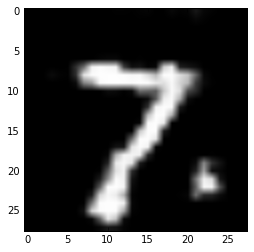

Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 1.7662... Generator Loss: 0.2323
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.3814
Epoch 2/2... Discriminator Loss: 1.7076... Generator Loss: 0.2425
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.3998
Epoch 2/2... Discriminator Loss: 1.6249... Generator Loss: 0.3011
Epoch 2/2... Discriminator Loss: 2.3761... Generator Loss: 2.7962
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 1.0745


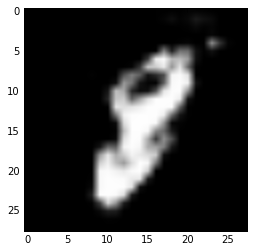

Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 1.7328
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 1.1340


In [83]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.8186... Generator Loss: 0.0730
Epoch 1/1... Discriminator Loss: 2.8066... Generator Loss: 0.0705
Epoch 1/1... Discriminator Loss: 3.5967... Generator Loss: 0.0389
Epoch 1/1... Discriminator Loss: 2.1698... Generator Loss: 0.1609
Epoch 1/1... Discriminator Loss: 1.7753... Generator Loss: 0.2734
Epoch 1/1... Discriminator Loss: 2.0193... Generator Loss: 0.2000
Epoch 1/1... Discriminator Loss: 1.9233... Generator Loss: 0.2223
Epoch 1/1... Discriminator Loss: 1.7497... Generator Loss: 0.3094
Epoch 1/1... Discriminator Loss: 1.7581... Generator Loss: 0.2769
Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 0.3244


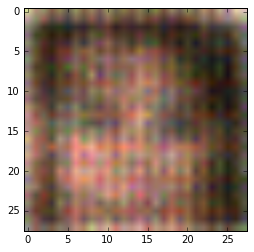

Epoch 1/1... Discriminator Loss: 1.8154... Generator Loss: 0.2605
Epoch 1/1... Discriminator Loss: 1.7884... Generator Loss: 0.2949
Epoch 1/1... Discriminator Loss: 1.8560... Generator Loss: 0.2344
Epoch 1/1... Discriminator Loss: 1.6634... Generator Loss: 0.3268
Epoch 1/1... Discriminator Loss: 1.6995... Generator Loss: 0.3100
Epoch 1/1... Discriminator Loss: 1.6797... Generator Loss: 0.2861
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.2970
Epoch 1/1... Discriminator Loss: 1.7786... Generator Loss: 0.2582
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8840


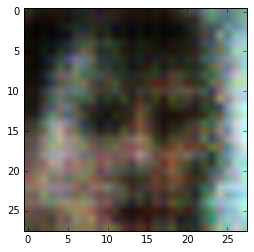

Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.3064
Epoch 1/1... Discriminator Loss: 2.1155... Generator Loss: 0.1800
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.6677... Generator Loss: 0.3819
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.4689


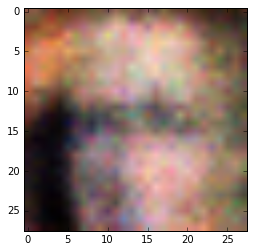

Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.6118... Generator Loss: 0.3891
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.5465


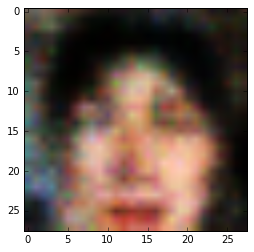

Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.4604
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6072


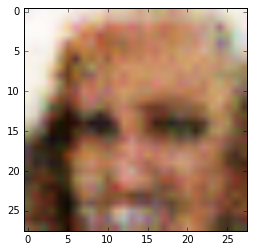

Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.5800


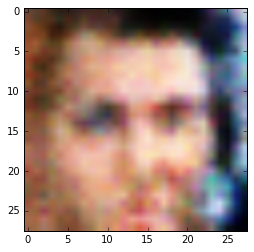

Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6073


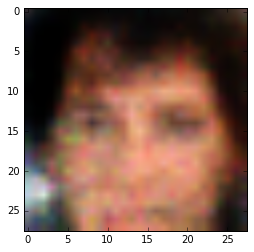

Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.5001


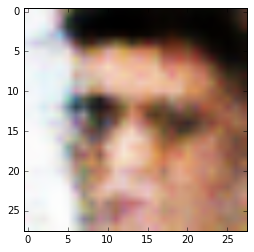

Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7913


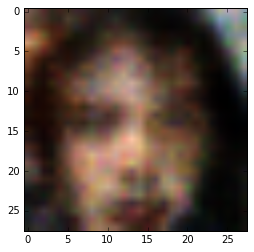

Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.4929
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.9601


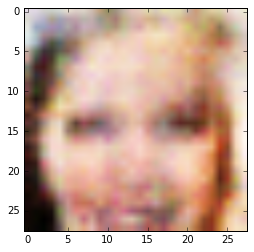

Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7417


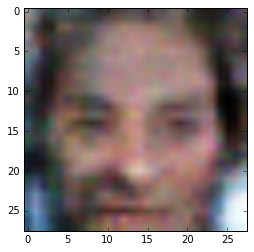

Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.6811


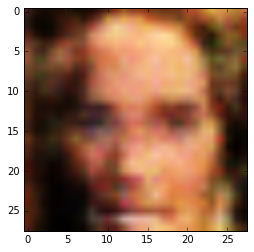

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.6538


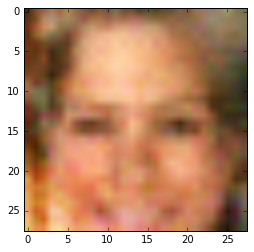

Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5509


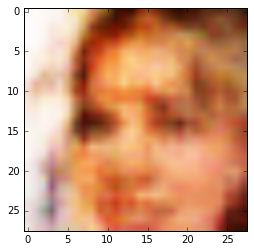

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.4882
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.4481


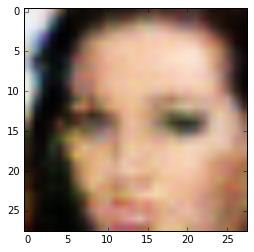

Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.7267


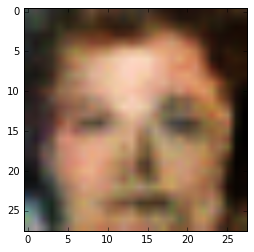

Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.4174


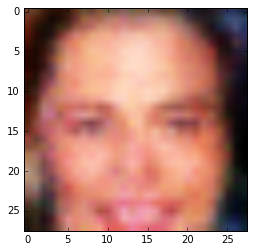

Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.7021


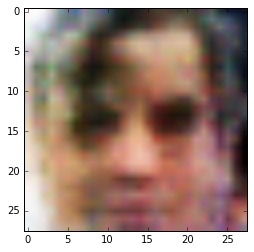

Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.5899


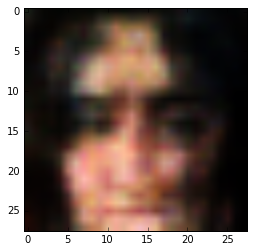

Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5063


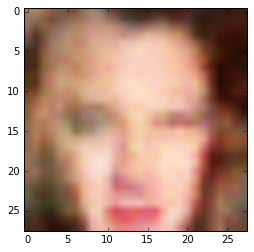

Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.4882
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.4398
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.5461


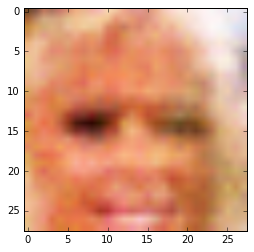

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.4784


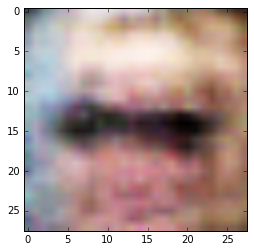

Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.5921


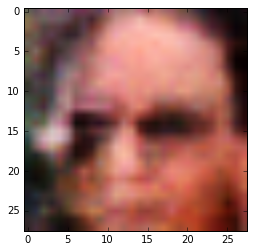

Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.5254


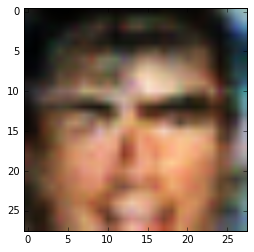

Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.4241
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.6180... Generator Loss: 0.3573
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7069


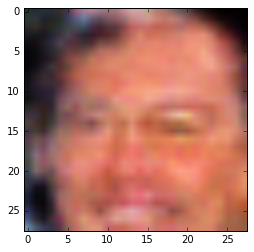

Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.3976
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.4272
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6313


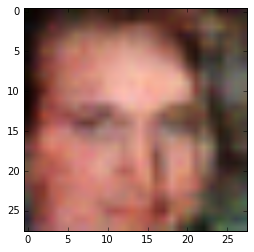

Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.4909


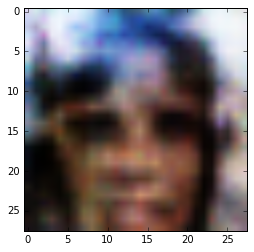

Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.8133... Generator Loss: 0.2591
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7723


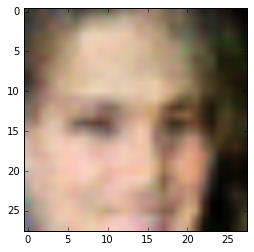

Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.7611


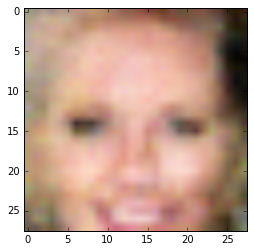

Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.3871
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6076


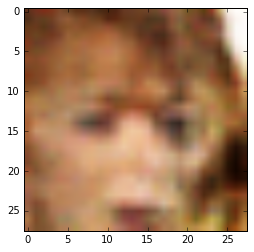

Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 1.6502... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.3722
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.5260


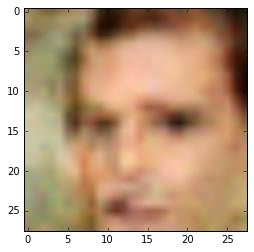

Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 0.3270
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.8123


In [84]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.